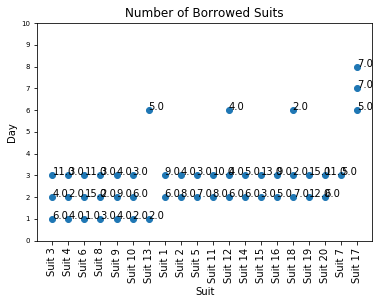

In [9]:
# -*- coding: utf-8 -*-
"""
Created on Sat Feb  9 11:37:18 2019

@author: Bharathy
"""

from pulp import *
import pandas as pd
import matplotlib.pyplot as plt

demand = pd.read_csv('demand.csv', header =0, index_col =['days'])
stock = pd.read_csv('inventory.csv', header =0, index_col=['Suit'])

days = demand.index

suits = stock.index

launderService = {'fast':{'Lead Time': 1,
                           'Cost':12},
                  'slow':{'Lead Time': 3,
                          'Cost':9}        
                  }

service = launderService.keys()
borrowCost = 15

#problem variable
prob = LpProblem('Minimize cost', LpMinimize)


#Variables
b = LpVariable.dicts('Borrowed Suits',((s,d) for s in suits for d in days),0, None, LpInteger)
l = LpVariable.dicts('laundry service', ((s,se,d) for s in suits for se in service for d in days))
i = LpVariable.dicts('Inventory at end of day d', ((s,d) for s in suits for d in days),0, None, LpInteger)
il = LpVariable.dicts('Suits sent to laundry at end of day d', ((s,d) for s in suits for d in days),0, None, LpInteger)

#objective function
prob +=  lpSum(borrowCost * b[s,d] for s in suits for d in days)\
        + lpSum(l[s,se,d]*launderService[se]['Cost'] \
                for s in suits for se in service for d in days)


#constraints
for d in days:
    for s in suits:
       if d > 2: 
           prob += lpSum(l[s,se,d] for se in service) + b[s,d] + i[s,d-1]\
                                                    == demand.loc[d,s] + i[s,d]
       if d==1:
           prob += b[s,d] + stock.loc[s] == demand.loc[d,s] + i[s,d]
       if d==2:
           prob += b[s,d] + i[s,d-1] == demand.loc[d,s] + i[s,d]
        
for d in days:
    for s in suits:
        prob += il[s,1] == 0
        if d > 1:
            prob +=  il[s,d] ==demand.loc[d-1,s]
        if d > 2:
            prob += l[s,'fast',d] <= il[s,d-2]
        if d > 4:
            prob += l[s,'slow',d] <= il[s,d-4]
        if d == 3:
            prob += l[s,'slow',d] ==0
        if d ==2:
            prob += l[s,'fast',d] ==0
        
prob.solve()

#display borrowed suits from nearby branch
borrow= {}
for d in days:
    for s in suits:
        borrow[s,d] = b[s,d].value()
                       
#split dictionary to list to create scatterplot
borrow_values = [i for i in borrow.values()]

#find indexes with value zero
delete_index=[]
for x in range(0,len(borrow_values)):
    if borrow_values[x] ==0:
        delete_index.append(x)

for i in sorted(delete_index, reverse= True):
    del borrow_values[i]


borrow_keys = [i for i in borrow]

for i in sorted(delete_index, reverse= True):
    del borrow_keys[i]
    
borrow_suits,borrow_days = zip(*borrow_keys)

plt.scatter(borrow_suits,borrow_days)
for i,s in enumerate(borrow_values):
    plt.annotate(s, (borrow_suits[i],borrow_days[i]))

plt.xticks(rotation=90)
plt.yticks(range(0,11))
plt.yticks(fontsize=7)
plt.xlabel('Suit')
plt.ylabel('Day')
plt.title('Number of Borrowed Suits') 

plt.show() 




# 